In [1]:
import random
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import dotenv

model_name = "google/gemma-2b"
g_file_path = "binary/g_gemma-2b.bin"
space_char = "_"

### load model ###
device = torch.device("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.float32,
                                             device_map="auto")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
RANDOM_UNEMBEDDINGS = False

### load unembdding vectors ###
gamma = model.get_output_embeddings().weight.detach()

if RANDOM_UNEMBEDDINGS:
    gamma = torch.randn_like(gamma)

W, d = gamma.shape
gamma_bar = torch.mean(gamma, dim = 0)
centered_gamma = gamma - gamma_bar

In [4]:
### compute Cov(gamma) and tranform gamma to g ###
Cov_gamma = centered_gamma.T @ centered_gamma / W
eigenvalues, eigenvectors = torch.linalg.eigh(Cov_gamma)
inv_sqrt_Cov_gamma = eigenvectors @ torch.diag(1/torch.sqrt(eigenvalues)) @ eigenvectors.T
sqrt_Cov_gamma = eigenvectors @ torch.diag(torch.sqrt(eigenvalues)) @ eigenvectors.T
g = centered_gamma @ inv_sqrt_Cov_gamma

In [5]:
Cov_gamma.shape, gamma.shape

(torch.Size([2048, 2048]), torch.Size([256000, 2048]))

In [2]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import warnings
warnings.filterwarnings('ignore')

vocab_dict = tokenizer.get_vocab() # token: index
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
animals = {
    "mammal": ["beaver", "panther", "lion", "llama", "colobus", "marmoset", "rabbit", "dingo", "pika", "okapi", "gazelle", "margay", "echidna", "vicuna", "grizzly", "aardvark", "anteater", "orangutan", "wallaby", "meerkat", "mongoose", "bongo", "hamster", "caracal", "whale", "addax", "boar", "puma", "peccary", "bonobo", "dolphin", "proboscis", "otter", "sheep", "capuchin", "howler", "guinea", "horse", "chinchilla", "donkey", "mandrill", "warthog", "galago", "takin", "impala", "eland", "springbok", "chimpanzee", "waterbuck", "moose", "nutria", "mink", "platypus", "mole", "ibex", "dormouse", "wolverine", "buffalo", "gorilla", "spermwhale", "fennec", "gerbil", "goat", "pangolin", "vole", "panda", "pronghorn", "polarbear", "gibbon", "jaguar", "fox", "agouti", "kudu", "snow-leopard", "finwhale", "gnu", "ape", "wombat", "tiger", "uakari", "dog", "saki", "hartebeest", "gemsbok", "pony", "redpanda", "jackal", "sloth", "alpaca", "muskox", "pig", "hedgehog", "coyote", "giraffe", "koala", "porpoise", "gelada", "chipmunk", "lynx", "lemur", "squirrel", "skunk", "topi", "hyena", "siamang", "walrus", "narwhal", "rodent", "cougar", "serow", "cat", "yak", "kangaroo", "tarsier", "elk", "chimp", "bison", "capybara", "papio", "armadillo", "tamarin", "black-bear", "loris", "ermine", "weasel", "hare", "monkey", "oryx", "camel", "ocelot", "marten", "beluga", "antelope", "caribou", "macaque", "rhinoceros", "ferret", "muskrat", "cheetah", "raccoon", "opossum", "deer", "langur", "sable", "gaur", "dugong", "zebu", "mule", "hippopotamus", "badger", "wolf", "manatee", "wildebeest", "shrew", "elephant", "rat", "tapir", "stoat", "baboon", "reindeer", "sea-lion", "polar-bear", "guanaco", "orca", "zebra", "cow", "porcupine", "leopard", "mouse"], 
    "bird": ["wigeon", "parrot", "albatross", "cockatoo", "magpie", "cardinal", "honeyeater", "hummingbird", "sedge", "kinglet", "kingfisher", "rhea", "plover", "thrush", "raven", "pelican", "ibis", "redshank", "mockingbird", "goldfinch", "tinamou", "cassowary", "chaffinch", "woodpecker", "peafowl", "cuckoo", "loon", "sunbird", "emu", "roadrunner", "waxwing", "harrier", "curlew", "godwit", "goose", "vulture", "avocet", "wagtail", "manakin", "snipe", "vireo", "partridge", "jay", "sandpiper", "dipper", "gadwall", "woodcock", "cotinga", "antpitta", "lovebird", "ptarmigan", "grebe", "hawk", "teal", "gnateater", "budgerigar", "oystercatcher", "osprey", "owl", "finch", "kite", "lorikeet", "wren", "hornbill", "turkey", "buzzard", "nightingale", "treecreeper", "tanager", "shoveler", "greenfinch", "puffin", "tern", "jacamar", "egret", "antbird", "tapaculo", "thrasher", "eagle", "brambling", "smew", "moorhen", "blackbird", "phalarope", "oriole", "toucan", "junco", "goldeneye", "turaco", "bunting", "flamingo", "keel", "redpoll", "macaw", "parakeet", "heron", "hoopoe", "duck", "sparrow", "catbird", "mallard", "coot", "flycatcher", "quail", "nuthatch", "bee-eater", "lapwing", "chicken", "guineafowl", "grosbeak", "swallow", "phoebe", "linnet", "kakapo", "cisticola", "kestrel", "ostrich", "dunlin", "reedbunting", "lark", "dove", "pintail", "falcon", "bullfinch", "pipit", "swan", "starling", "pheasant", "kiwi", "eider", "grouse", "pigeon", "shrike", "stork", "warbler", "cormorant", "merganser", "crossbill", "seagull", "canary", "scoter", "siskin"], 
    "reptile": ["viper", "lizard", "terrapin", "cobra", "anaconda", "gila", "skink", "crocodile", "anole", "iguana", "chameleon", "mamba", "gecko", "komodo", "snake", "tortoise", "alligator", "turtle", "tuatara"], 
    "fish": ["snapper", "anchovy", "moonfish", "herring", "dolphinfish", "pomfret", "crab", "barracuda", "arowana", "ladyfish", "salmon", "dace", "scallop", "carp", "eel", "flounder", "spadefish", "tilapia", "boxfish", "croaker", "goosefish", "pollock", "trout", "seahorse", "shark", "jewfish", "grayling", "tench", "mahi-mahi", "halibut", "bonefish", "ide", "urchin", "piranha", "rockfish", "swordtail", "tuna", "surgeonfish", "smelt", "mackerel", "sockeye", "fluke", "chub", "starfish", "tarpon", "pompano", "monkfish", "moray", "cod", "catfish", "clam", "ribbonfish", "rudd", "sturgeon", "coho", "jellyfish", "bitterling", "grunt", "roach", "pipefish", "weakfish", "grouper", "snook", "swordfish", "lingcod", "clownfish", "oyster", "haddock", "angelfish", "mussel", "sardine", "platy", "scorpionfish", "chinook", "triggerfish", "amberjack", "sablefish", "guppy", "mahi", "discus", "puffer", "mullet", "lobster", "kingfish", "pleco", "whitefish", "perch", "gar", "barbel", "shrimp", "bream", "wrass", "pike", "damselfish", "lionfish", "goldfish", "cichlid", "bleak", "scup", "bluefish"], 
    "amphibian": ["bullfrog", "siren", "toad", "treefrog", "frog", "olm", "axolotl", "surinam", "natterjack", "hellbender", "salamander", "tadpole", "glassfrog", "mudpuppy", "newt", "caecilian"], 
    "insect": ["mayfly", "grasshopper", "bedbug", "silverfish", "cicada", "dragonfly", "lacewing", "leech", "butterfly", "damselfly", "housefly", "termite", "earwig", "slug", "moth", "flea", "earthworm", "mosquito", "hornet", "snail", "ladybug", "cockroach", "gnat", "scarab", "scorpion", "caterpillar", "aphid", "thrips", "weevil", "beetle", "tarantula", "firefly", "millipede", "spider", "cricket", "wasp", "ant", "centipede", "mite", "bee"]
    }

emotions = {
    'joy': ['mirth', 'thrill', 'bliss', 'relief', 'admiration', 'affection', 'serenity', 'inspiration', 'gladness', 'adoration', 'delight', 'love', 'hilarity', 'buoyancy', 'gaiety', 'zeal', 'vibrancy', 'compassion', 'fulfillment', 'exhilaration', 'happiness', 'gratitude', 'pride', 'triumph', 'tenderness', 'zest', 'rapture', 'euphoria', 'glee', 'blissfulness', 'enthusiasm', 'cheerfulness', 'pleasure', 'excitement', 'hopefulness', 'joviality', 'carefree', 'satisfaction', 'elation', 'lightheartedness', 'comfort', 'contentment', 'ecstasy', 'warmth', 'awe', 'tranquility', 'radiance', 'jubilation', 'playfulness', 'optimism', 'wonder', 'vivacity', 'fondness', 'amusement'], 
    'sadness': ['dejection', 'anguish', 'nostalgia', 'melancholy', 'despondency', 'desperation', 'grieving', 'guilt', 'miserableness', 'gloom', 'loneliness', 'discouragement', 'defeatism', 'hollowness', 'listlessness', 'mourning', 'desolation', 'woe', 'pessimism', 'tearfulness', 'apathy', 'homesickness', 'abandonment', 'numbness', 'sulkiness', 'bleakness', 'yearning', 'pining', 'heartbreak', 'resentment', 'alienation', 'grief', 'regret', 'wistfulness', 'disillusionment', 'sorrow', 'lethargy', 'resignation', 'heartache', 'world-weariness', 'disappointment', 'emptiness', 'depression', 'despair', 'hopelessness', 'isolation', 'longing', 'weariness', 'remorse', 'shame', 'forlornness', 'bitterness', 'misery', 'blues'], 
    'anger': ['displeasure', 'spite', 'irritation', 'disdain', 'disgruntlement', 'rage', 'ire', 'wrath', 'competitiveness', 'hostility', 'fury', 'chagrin', 'petulance', 'indignation', 'exasperation', 'malice', 'contempt', 'venom', 'irascibility', 'ferocity', 'scorn', 'enmity', 'antagonism', 'rivalry', 'irksomeness', 'crabbiness', 'jealousy', 'disgust', 'resentment', 'frustration', 'grumpiness', 'vindictiveness', 'vengefulness', 'animosity', 'antipathy', 'violence', 'loathing', 'outrage', 'cantankerousness', 'envy', 'hatred', 'temperament', 'vexation', 'combativeness', 'aggression', 'pique', 'agitation', 'grudge', 'bitterness', 'huffiness', 'belligerence', 'annoyance'], 
    'fear': ['nervousness', 'paranoia', 'discomfort', 'helplessness', 'restlessness', 'aversion', 'alertness', 'alarm', 'uncertainty', 'foreboding', 'fearfulness', 'panic', 'confusion', 'shock', 'worry', 'insecurity', 'disorientation', 'stress', 'trepidation', 'shyness', 'overwhelm', 'dread', 'startlement', 'revulsion', 'fright', 'self-doubt', 'terror', 'squeamishness', 'phobia', 'distress', 'inadequacy', 'reluctance', 'mistrust', 'anxiety', 'wariness', 'timidity', 'indecision', 'angst', 'hesitation', 'unease', 'apprehension', 'tension', 'vulnerability', 'horror', 'jitters', 'agitation', 'presentiment', 'dismay', 'caution', 'bewilderment', 'suspicion'], 
    'surprise': ['enthrallment', 'unexpectedness', 'revitalization', 'inquisitiveness', 'rejuvenation', 'discovery', 'unpredictability', 'stimulation', 'confusion', 'marvel', 'shock', 'disbelief', 'jolting', 'skepticism', 'dubiety', 'epiphany', 'incredulity', 'puzzlement', 'stupor', 'revelation', 'novelty', 'disorientation', 'amazement', 'realization', 'eureka', 'refreshment', 'stunned', 'awe-struck', 'dumbfounded', 'astonied', 'astonishment', 'startlement', 'excitement', 'fascination', 'animation', 'engrossment', 'intrigue', 'awe', 'flabbergasted', 'captivation', 'vivification', 'startled', 'wonderment', 'staggered', 'wonder', 'eye-opening', 'bewilderment', 'unfamiliarity', 'arousal', 'stupefaction', 'perplexity', 'curiosity', 'invigoration'], 
    'disgust': ['detestation', 'displeasure', 'prudishness', 'disdain', 'aversion', 'bothered', 'perturbed', 'sneering', 'pretentiousness', 'sanctimoniousness', 'mockery', 'contempt', 'scorn', 'dislike', 'arrogance', 'fussiness', 'repulsion', 'snobbishness', 'offensiveness', 'nausea', 'derision', 'abhorrence', 'disapprobation', 'sarcasm', 'disapproval', 'condescension', 'queasiness', 'offense', 'pickiness', 'alienation', 'superciliousness', 'revulsion', 'repugnance', 'finickiness', 'squeamishness', 'self-righteousness', 'antipathy', 'fastidiousness', 'repulsiveness', 'loathing', 'rejection', 'sickness', 'outrage', 'haughtiness', 'primness', 'obnoxiousness', 'pomposity', 'ridicule', 'egotism', 'affectation', 'superiority', 'repellence', 'nauseousness', 'vanity', 'distaste', 'cynicism']
    }

nonsense = {
    "random 1": ["toaster", "penguin", "jelly", "cactus", "submarine", "marble", "accordion", "cheese", "volcano", "pepper", "trombone", "zebra", "bicycle", "napkin", "iguana", "waterfall", "spatula", "pyramid", "cloud", "lantern", "shoebox", "squid", "rubber", "iceberg", "chocolate", "boomerang", "spaghetti", "eraser", "ladle", "tsunami", "windmill", "comb", "raven", "alarm", "cucumber", "lightning", "quartz", "flip-flop", "parachute", "snowman", "bottle", "puzzle"],
    "random 2": ["sandwich", "yo-yo", "plank", "rainbow", "monocle", "snowflake", "ladder", "coconut", "spaceship", "umbrella", "pebble", "keyboard", "straw", "pineapple", "screw", "mountain", "seashell", "whisk", "blender", "radio", "crater", "toothpaste", "zeppelin", "otter", "paintbrush", "sundial", "mirrorball", "bonsai", "handkerchief", "muffin", "telescope", "pothole", "skillet", "salmon", "glue", "jungle", "elevator", "compass", "butter", "drumstick", "satellite"],
    "random 3": ["kiwi", "tornado", "chopstick", "helicopter", "sunflower", "giraffe", "whistle", "bookcase", "crayon", "dragon", "pogo-stick", "barnacle", "treasure", "firefly", "dinosaur", "shoelace", "lava", "violin", "mailbox", "saxophone", "parrot", "paperclip", "tinsel", "whirlpool", "cookie", "speedboat", "broomstick", "potato", "scarecrow", "goblin", "clownfish", "icecream", "fossil", "flagpole", "firework", "basket", "thimble", "beacon", "spoon", "ostrich", "canoe"],
    "random 4": ["ocean", "microscope", "tiger", "pasta", "umbrella", "helicopter", "mirror", "popcorn", "dolphin", "soap", "sailboat", "tangerine", "grapefruit", "pencil", "chandelier", "toothbrush", "igloo", "skateboard", "canoe", "lava-lamp", "mango", "suitcase", "spider", "bubble", "sprinkler", "yo-yo", "helmet", "carousel", "sandpaper", "hurricane", "microphone", "pogo-stick", "flamingo", "matchstick", "grape", "shoelace", "hedgehog", "rocket", "geyser", "yo-yo", "quicksand"],
    "random 5": ["banjo", "skyscraper", "avocado", "sphinx", "teacup", "hammock", "kite", "gorilla", "pinecone", "marshmallow", "carpet", "lighthouse", "moose", "cookie", "train", "firetruck", "jigsaw", "tulip", "skeleton", "bobsled", "coconut", "lamppost", "kangaroo", "pear", "raccoon", "toolbox", "bubblegum", "picnic", "pottery", "spoon", "toadstool", "velvet", "cloud", "sunscreen", "bathtub", "apple", "lawnmower", "bat", "harp", "airplane", "pickle"]
}

data = animals
base_class = 'animals'

categories = list(data.keys())

for category in categories:
    print(category, len(data[category]))

mammal 169
bird 142
reptile 19
fish 100
amphibian 16
insect 40


In [35]:
import inflect
p = inflect.engine()

def noun_to_gemma_vocab_elements(word, vocab_set, space_char: str = "▁"):
    word = word.lower()
    plural = p.plural(word)
    add_cap_and_plural = [word, word.capitalize(), plural, plural.capitalize()]
    add_space = [space_char + w for w in add_cap_and_plural]
    return vocab_set.intersection(add_space)

def get_data_category(data, categories, vocab_dict, g, space_char: str = "▁"):
    vocab_set = set(vocab_dict.keys())

    datas = {}
    datas_ind = {}
    datas_g = {}
    datas_token = {}

    for category in categories:
        datas[category] = []
        datas_ind[category] = []
        datas_token[category] = []
        datas_g[category] = []

    for category in categories:
        lemmas = data[category]
        for w in lemmas:
            datas[category].extend(noun_to_gemma_vocab_elements(w, vocab_set, space_char=space_char))
        
        for word in datas[category]:
            datas_ind[category].append(vocab_dict[word])
            datas_token[category].append(word)
            datas_g[category] = g[datas_ind[category]]
    return datas_token, datas_ind, datas_g

from sklearn.covariance import ledoit_wolf

def category_to_indices(category, vocab_dict):
    return [vocab_dict[w] for w in category]

def get_words_sim_to_vec(query: torch.tensor, unembed, vocab_list, k=300):
    similar_indices = torch.topk(unembed @ query, k, largest=True).indices.cpu().numpy()
    return [vocab_list[idx] for idx in similar_indices]

def estimate_single_dir_from_embeddings(category_embeddings):
    category_mean = category_embeddings.mean(dim=0)
    # print(f"category_mean shape: {category_mean.shape}")

    cov = ledoit_wolf(category_embeddings.cpu().numpy())
    cov = torch.tensor(cov[0], device = category_embeddings.device)
    # print(f"cov shape: {cov.shape}")
    pseudo_inv = torch.linalg.pinv(cov)
    lda_dir = pseudo_inv @ category_mean
    lda_dir = lda_dir / torch.norm(lda_dir)
    # print(f"lda_dir shape: {lda_dir.shape}")
    lda_dir = (category_mean @ lda_dir) * lda_dir

    return lda_dir, category_mean

def estimate_cat_dir(category_lemmas, unembed, vocab_dict):
    category_embeddings = unembed[category_to_indices(category_lemmas, vocab_dict)]
    # print(category_embeddings.shape)
    lda_dir, category_mean = estimate_single_dir_from_embeddings(category_embeddings)
    
    return {'lda': lda_dir, 'mean': category_mean}

def get_cat_lemma_dirs(category_lemmas, unembed, vocab_dict):
    category_embeddings = unembed[category_to_indices(category_lemmas, vocab_dict)]
    
    return category_embeddings

def process_dirs(dir1, dir2):
    # normalize and orthogonalize
    dir1 = dir1 / torch.norm(dir1)
    dir2 = dir2 - (dir2 @ dir1) * dir1
    dir2 = dir2 / torch.norm(dir2)
    return dir1, dir2

In [36]:
datas_token, datas_ind, datas_g = get_data_category(data, categories,  vocab_dict, g)

dirs = {k: estimate_cat_dir(v, g, vocab_dict) for k, v in datas_token.items()}

all_datas_tokens = [a for k, v in datas_token.items() for a in v]
dirs.update({base_class: estimate_cat_dir(all_datas_tokens, g, vocab_dict)})
datas_token.update({base_class: all_datas_tokens})

categories = categories + [base_class, 'all vocab']

datas_token['all vocab'] = random.sample(vocab_list, 10000)

# indices = [base_class, "random 1"]
# indices = [base_class, "sadness"]
indices = [base_class, "mammal"]

inds0 = {idx: category_to_indices(datas_token[idx], vocab_dict) for idx in indices}

dir1, dir2 = (dirs[idx]["lda"] for idx in indices)

cat_lemma_dirs = {
    category: get_cat_lemma_dirs(datas_token[category], g, vocab_dict)
    for category in categories
}

dir1, dir2 = process_dirs(dir1, dir2)

In [37]:
all_bird_indices = category_to_indices(datas_token['bird'], vocab_dict)
all_mammal_indices = category_to_indices(datas_token['mammal'], vocab_dict)

# all_sadness_indices = category_to_indices(datas_token['sadness'], vocab_dict)
# all_joy_indices = category_to_indices(datas_token['joy'], vocab_dict)

# all_random_1_indices = category_to_indices(datas_token['random 1'], vocab_dict)
# all_random_2_indices = category_to_indices(datas_token['random 2'], vocab_dict)

In [38]:
combined_reps = torch.cat([g[all_mammal_indices], g[all_bird_indices]], dim=0)
# combined_reps = torch.cat([g[all_sadness_indices], g[all_joy_indices]], dim=0)
# combined_reps = torch.cat([g[all_random_1_indices], g[all_random_2_indices]], dim=0)
combined_reps = combined_reps - combined_reps.mean(dim=0)

print(combined_reps.shape)

torch.Size([309, 2048])


In [39]:
# cat1 = 'sadness'
# cat2 = 'joy'
cat1 = 'mammal'
cat2 = 'bird'

# use plotly to 2D plot the similarity of each mammal and bird to each mammal and bird
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(combined_reps.cpu().numpy())

fig = go.Figure(data=go.Heatmap(
                     z=similarity_matrix,
                     x=datas_token[cat1] + datas_token[joy],
                     y=datas_token[cat1] + datas_token[joy],
                     colorscale='RdBu',
                     zmid=0)
                    )

fig.update_layout(
    title=f'Cosine similarity between each {cat1} and {cat2}',
    xaxis_nticks=36)

# square aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=600)

# draw a line to separate the two categories

fig.add_shape(
    # Line Horizontal
    type="line",
    x0=0,
    y0=len(datas_token[cat1]),
    x1=len(datas_token[cat1]) + len(datas_token[joy]),
    y1=len(datas_token[cat1]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

fig.add_shape(
    # Line Vertical
    type="line",
    x0=len(datas_token[cat1]),
    y0=0,
    x1=len(datas_token[cat1]),
    y1=len(datas_token[cat1]) + len(datas_token[joy]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

# add text for each category

fig.add_annotation(
    x=len(datas_token[cat1]) / 2,
    y=len(datas_token[cat1]) + len(datas_token[joy]) / 2,
    text="Bird v Mammal",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.add_annotation(
    x=len(datas_token[cat1]) + len(datas_token[joy]) / 2,
    y=len(datas_token[cat1]) / 2,
    text="Mammal v Bird",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.show()

NameError: name 'joy' is not defined

In [ ]:
# get average similarity of each mammal to all other mammals and all birds
# and average similarity of each bird to all other birds and all mammals

mammal_similarities = similarity_matrix[:len(datas_token['mammal']), :len(datas_token['mammal'])]
bird_similarities = similarity_matrix[len(datas_token['mammal']):, len(datas_token['mammal']):]

print(f"Average similarity of each mammal to all other mammals: {mammal_similarities.mean()}")
print(f"Average similarity of each bird to all other birds: {bird_similarities.mean()}")

print(f"Average similarity of each mammal to all birds: {similarity_matrix[:len(datas_token['mammal']), len(datas_token['mammal']):].mean()}")

Average similarity of each mammal to all other mammals: 0.011587949469685555
Average similarity of each bird to all other birds: 0.028723297640681267
Average similarity of each mammal to all birds: -0.018065404146909714
Average similarity of each bird to all mammals: -0.018065404146909714


In [ ]:
cat1 = 'sadness'
cat2 = 'joy'

# use plotly to 2D plot the similarity of each mammal and bird to each mammal and bird
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(combined_reps.cpu().numpy())

fig = go.Figure(data=go.Heatmap(
                     z=similarity_matrix,
                     x=datas_token[cat1] + datas_token[cat2],
                     y=datas_token[cat1] + datas_token[cat2],
                     colorscale='RdBu',
                     zmid=0)
                    )

fig.update_layout(
    title=f'Cosine similarity between each {cat1} and {cat2}',
    xaxis_nticks=36)

# square aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=600)

# draw a line to separate the two categories

fig.add_shape(
    # Line Horizontal
    type="line",
    x0=0,
    y0=len(datas_token[cat1]),
    x1=len(datas_token[cat1]) + len(datas_token[cat2]),
    y1=len(datas_token[cat1]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

fig.add_shape(
    # Line Vertical
    type="line",
    x0=len(datas_token[cat1]),
    y0=0,
    x1=len(datas_token[cat1]),
    y1=len(datas_token[cat1]) + len(datas_token[cat2]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

# add text for each category

fig.add_annotation(
    x=len(datas_token[cat1]) / 2,
    y=len(datas_token[cat1]) + len(datas_token[cat2]) / 2,
    text=f"{cat1} v {cat2}",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.add_annotation(
    x=len(datas_token[cat1]) + len(datas_token[cat2]) / 2,
    y=len(datas_token[cat1]) / 2,
    text=f"{cat2} v {cat1}",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.show()

In [ ]:
# get average similarity of each sadness to all other sadness and all joy
# and average similarity of each joy to all other joy and all sadness

sadness_similarities = similarity_matrix[:len(datas_token['sadness']), :len(datas_token['sadness'])]
joy_similarities = similarity_matrix[len(datas_token['sadness']):, len(datas_token['sadness']):]

print(f"Average similarity of each sadness to all other sadness: {sadness_similarities.mean()}")
print(f"Average similarity of each joy to all other joy: {joy_similarities.mean()}")
print(f"Average similarity of each sadness to all joy: {similarity_matrix[:len(datas_token['sadness']), len(datas_token['sadness']):].mean()}")

Average similarity of each sadness to all other sadness: 0.04257405921816826
Average similarity of each joy to all other joy: 0.025101466104388237
Average similarity of each sadness to all joy: -0.03246056288480759


In [ ]:
cat1 = 'random 1'
cat2 = 'random 2'

# use plotly to 2D plot the similarity of each mammal and bird to each mammal and bird
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(combined_reps.cpu().numpy())

fig = go.Figure(data=go.Heatmap(
                     z=similarity_matrix,
                     x=datas_token[cat1] + datas_token[cat2],
                     y=datas_token[cat1] + datas_token[cat2],
                     colorscale='RdBu',
                     zmid=0)
                    )

fig.update_layout(
    title=f'Cosine similarity between each {cat1} and {cat2}',
    xaxis_nticks=36)

# square aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=600)

# draw a line to separate the two categories

fig.add_shape(
    # Line Horizontal
    type="line",
    x0=0,
    y0=len(datas_token[cat1]),
    x1=len(datas_token[cat1]) + len(datas_token[cat2]),
    y1=len(datas_token[cat1]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

fig.add_shape(
    # Line Vertical
    type="line",
    x0=len(datas_token[cat1]),
    y0=0,
    x1=len(datas_token[cat1]),
    y1=len(datas_token[cat1]) + len(datas_token[cat2]),
    line=dict(
        color="Black",
        width=3,
        dash="dashdot",
    )
)

# add text for each category

fig.add_annotation(
    x=len(datas_token[cat1]) / 2,
    y=len(datas_token[cat1]) + len(datas_token[cat2]) / 2,
    text=f"{cat1} v {cat2}",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.add_annotation(
    x=len(datas_token[cat1]) + len(datas_token[cat2]) / 2,
    y=len(datas_token[cat1]) / 2,
    text=f"{cat2} v {cat1}",
    showarrow=False,
    font=dict(
        family="Sans Serif",
        size=16,
        color="black"
    )
)

fig.show()

In [10]:
# get average similarity of each random 1 to all other random 1 and all random 2
# and average similarity of each random 2 to all other random 2 and all random 1

random_1_similarities = similarity_matrix[:len(datas_token['random 1']), :len(datas_token['random 1'])]
random_2_similarities = similarity_matrix[len(datas_token['random 1']):, len(datas_token['random 1']):]

print(f"Average similarity of each random 1 to all other random 1: {random_1_similarities.mean()}")
print(f"Average similarity of each random 2 to all other random 2: {random_2_similarities.mean()}")
print(f"Average similarity of each random 1 to all random 2: {similarity_matrix[:len(datas_token['random 1']), len(datas_token['random 1']):].mean()}")

Average similarity of each random 1 to all other random 1: 0.004787536337971687
Average similarity of each random 2 to all other random 2: 0.006089638918638229
Average similarity of each random 1 to all random 2: -0.00539694307371974


In [40]:
colors = [
    "#808080",     # gray
    "#0000FF",     # blue
    "#FF0000",     # red
    "#800080",     # purple
    "#008000",     # green
    "#FFFF00",     # yellow
    "#00FFFF",     # cyan
]

In [41]:
categories_to_plot = ["all vocab", base_class, "mammal"]
# categories_to_plot = ["all vocab", "joy", "sadness"]
# categories_to_plot = ["all vocab", base_class, "random 1", "random 2"]

In [42]:
x = {category: (cat_lemma_dirs[category] @ dir1).cpu().numpy() for category in categories_to_plot}
y = {category: (cat_lemma_dirs[category] @ dir2).cpu().numpy() for category in categories_to_plot}

dir1 = dir1.cpu().numpy()
dir2 = dir2.cpu().numpy()

In [43]:
fig = go.Figure()

for c, category in enumerate(categories_to_plot):
    fig.add_trace(go.Scatter(x=x[category], y=y[category], mode='markers', name=category,
                             marker=dict(size=5 if category != "all vocab" else 1, opacity=1 if category != "all vocab" else 0.3, color=colors[c])))

fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.1), yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.1))

# finer grid lines

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# grid should show at every 0.4 and be orange

fig.update_xaxes(tick0=0, dtick=2, gridcolor='gray')
fig.update_yaxes(tick0=0, dtick=2, gridcolor='gray')

fig.update_xaxes(zeroline=True, zerolinecolor='black', zerolinewidth=2)
fig.update_yaxes(zeroline=True, zerolinecolor='black', zerolinewidth=2)

fig.update_xaxes(title_text=indices[0])
fig.update_yaxes(title_text=indices[1])

lim = 11
fig.update_xaxes(range=[-lim, lim])
fig.update_yaxes(range=[-lim, lim])

fig.update_layout(width=500, height=500)

# show lengend on figure inside a small box at the top left

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))  # No margins

fig.show()

In [49]:
fig = go.Figure()

for c, category in enumerate(categories_to_plot):
    fig.add_trace(go.Scatter(x=x[category], y=y[category], mode='markers', name=category,
                             marker=dict(size=5 if category != "all vocab" else 1, opacity=1 if category != "all vocab" else 0.3, color=colors[c])))

fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.1), yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.1))

# finer grid lines

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# grid should show at every 0.4 and be orange

fig.update_xaxes(tick0=0, dtick=2, gridcolor='gray')
fig.update_yaxes(tick0=0, dtick=2, gridcolor='gray')

fig.update_xaxes(zeroline=True, zerolinecolor='black', zerolinewidth=2)
fig.update_yaxes(zeroline=True, zerolinecolor='black', zerolinewidth=2)

fig.update_xaxes(title_text=indices[0])
fig.update_yaxes(title_text=indices[1])

lim = 11
fig.update_xaxes(range=[-lim, lim])
fig.update_yaxes(range=[-lim, lim])

fig.update_layout(width=500, height=500)

# show lengend on figure inside a small box at the top left

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))  # No margins

fig.show()

In [50]:
# save as high quality png with no space around the plot
fig.write_image("figures/animals-random-unembed-2d.png", scale=10, width=500, height=500)

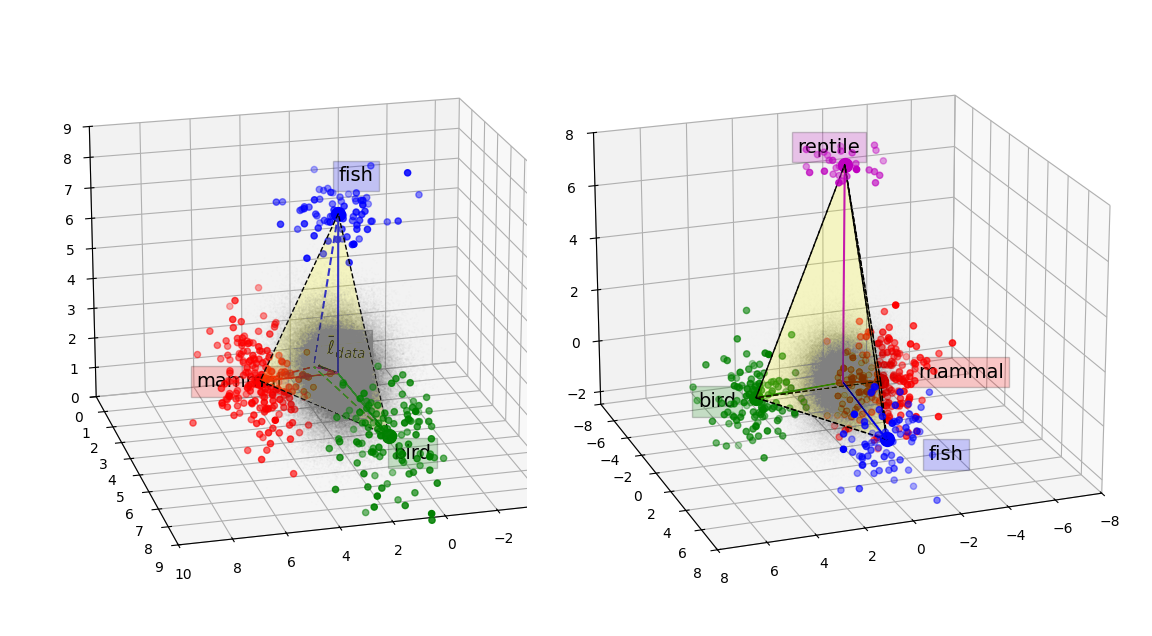

In [47]:
# animals
cats_plot1 = ["mammal", "bird", "fish"]
cats_plot2 = ["mammal", "bird", "fish", "reptile"]

# nonsense
# cats_plot1 = ["random 1", "random 2", "random 3"]
# cats_plot2 = ["random 1", "random 2", "random 3", "random 4"]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')

cat1 = cats_plot1[0]
cat2 = cats_plot1[1]
cat3 = cats_plot1[2]

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
higher_dir = dirs[base_class]["lda"]

xaxis = dir1 / dir1.norm()
yaxis = dir2 - (dir2 @ xaxis) * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = category_to_indices(datas_token[cat1], vocab_dict)
ind2 = category_to_indices(datas_token[cat2], vocab_dict)
ind3 = category_to_indices(datas_token[cat3], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (higher_dir @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)

verts = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle = Poly3DCollection(verts, alpha=.2, linewidths=1, linestyle =  "--", edgecolors='k')
triangle.set_facecolor('yellow')
ax.add_collection3d(triangle)

ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='k', arrow_length_ratio=0.1, linewidth=2)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.03)

scale = 1.2
ax.text(P1[0]*scale + 2, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2), fontsize=14)
ax.text(P2[0]*scale+0.5, P2[1]* scale+0.5, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2), fontsize=14)
ax.text(P3[0]*scale, P3[1]* scale, P3[2]*scale, cat3, bbox=dict(facecolor='b', alpha=0.2), fontsize=14)
ax.text(P4[0]-0.6, P4[1]-0.6, P4[2], rf'$\bar{{\ell}}_{{data}}$', bbox=dict(facecolor='k', alpha=0.2), fontsize=14)

normal_vector = np.cross(P2 - P1, P3 - P1)
normal_vector = normal_vector / np.linalg.norm(normal_vector)
normal_mag = P1 @ normal_vector
normal_vector = normal_vector * normal_mag

P1_normal = P1 - normal_vector
P2_normal = P2 - normal_vector
P3_normal = P3 - normal_vector

ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P1_normal[0], P1_normal[1], P1_normal[2],
          color='r', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P2_normal[0], P2_normal[1], P2_normal[2],
          color='g', linestyle =  "--", arrow_length_ratio=0.01)
ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P3_normal[0], P3_normal[1], P3_normal[2],
          color='b', linestyle =  "--", arrow_length_ratio=0.01)

ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='purple',
          linestyle =  "--", arrow_length_ratio=0.01)


ax.set_xlim(-5, 10)
ax.set_ylim(0, 9)
ax.set_zlim(0, 9)

# ax.set_xlim(0, 13)
# ax.set_ylim(0, 12)
# ax.set_zlim(0, 11)

ax.view_init(elev=20, azim=75)
plt.subplots_adjust(wspace=-0.5)



### Second Plot
ax = fig.add_subplot(122, projection='3d')
cat1 = cats_plot2[0]
cat2 = cats_plot2[1]
cat3 = cats_plot2[2]
cat4 = cats_plot2[3]

dir1 = dirs[cat1]["lda"]
dir2 = dirs[cat2]["lda"]
dir3 = dirs[cat3]["lda"]
dir4 = dirs[cat4]["lda"]

xaxis = (dir2 - dir1) / (dir2-dir1).norm()
yaxis = dir3 - dir1 - (dir3-dir1) @ xaxis * xaxis
yaxis = yaxis / yaxis.norm()
zaxis = (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
zaxis = zaxis / zaxis.norm()

axes = torch.stack([xaxis, yaxis, zaxis], dim=1)

ind1 = category_to_indices(datas_token[cat1], vocab_dict)
ind2 = category_to_indices(datas_token[cat2], vocab_dict)
ind3 = category_to_indices(datas_token[cat3], vocab_dict)
ind4 = category_to_indices(datas_token[cat4], vocab_dict)

g1 = g[ind1]
g2 = g[ind2]
g3 = g[ind3]
g4 = g[ind4]

proj1 = (g1 @ axes).cpu().numpy()
proj2 = (g2 @ axes).cpu().numpy()
proj3 = (g3 @ axes).cpu().numpy()
proj4 = (g4 @ axes).cpu().numpy()
proj = (g @ axes).cpu().numpy()

P1 = (dir1 @ axes).cpu().numpy()
P2 = (dir2 @ axes).cpu().numpy()
P3 = (dir3 @ axes).cpu().numpy()
P4 = (dir4 @ axes).cpu().numpy()

ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)
ax.scatter(P4[0], P4[1], P4[2], color='m', s=100)

verts1 = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
triangle1 = Poly3DCollection(verts1, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle1.set_facecolor('yellow')
ax.add_collection3d(triangle1)

verts2 = [list(zip([P1[0], P2[0], P4[0]], [P1[1], P2[1], P4[1]], [P1[2], P2[2], P4[2]]))]
triangle2 = Poly3DCollection(verts2, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle2.set_facecolor('yellow')
ax.add_collection3d(triangle2)

verts3 = [list(zip([P1[0], P3[0], P4[0]], [P1[1], P3[1], P4[1]], [P1[2], P3[2], P4[2]]))]
triangle3 = Poly3DCollection(verts3, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle3.set_facecolor('yellow')
ax.add_collection3d(triangle3)

verts4 = [list(zip([P2[0], P3[0], P4[0]], [P2[1], P3[1], P4[1]], [P2[2], P3[2], P4[2]]))]
triangle4 = Poly3DCollection(verts4, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
triangle4.set_facecolor('yellow')
ax.add_collection3d(triangle4)


ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='m', arrow_length_ratio=0.01)


scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=cat1)
scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=cat2)
scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=cat3)
scatter4 = ax.scatter(proj4[:,0], proj4[:,1], proj4[:,2], c='m', label=cat4)
scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.01)


scale = 1.4
scale2 = 1.2
ax.text(P1[0]*scale-1, P1[1]* scale, P1[2]*scale, cat1, bbox=dict(facecolor='r', alpha=0.2), fontsize=14)
ax.text(P2[0]*scale+1, P2[1]* scale, P2[2]*scale, cat2, bbox=dict(facecolor='g', alpha=0.2), fontsize=14)
ax.text(P3[0]*scale-1, P3[1]* scale, P3[2]*scale, cat3, bbox=dict(facecolor='b', alpha=0.2), fontsize=14)
ax.text(P4[0]*scale2+2, P4[1]* scale2, P4[2]*scale2-1, cat4, bbox=dict(facecolor='m', alpha=0.2), fontsize=14)

# ax.set_xlim(-8,10)
# ax.set_ylim(-8,10)
# ax.set_zlim(-2.5, 8)

ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_zlim(-2.5, 8)

ax.view_init(elev=20, azim=70)
plt.subplots_adjust(wspace=-0.5)

# plt.tight_layout(pad=0)
fig.savefig(f"figures/random_animal_3d.png", bbox_inches='tight', dpi=300)
plt.show()